Instructions
-------------
This notebook goes from micro-variable climate data (same data as used in our UAI 2016 paper "Unsupervised Discovery of El Nino Using Causal Feature Learning on Micro-Level Climate Data") to macro-level states. 

I simplified our code a little bit, but you should at least get a "Westerly Winds" and "El Nino" clusters at the end of this notebook, and see that they correlate strongly.

To use your own data, you only need to modify the "The Dataset" cell -- substitute your own data for our X and Y arrays. 

If you like, you can also experiment with neural net training in the "Learning P(Y | X)" cell. Make sure the validation error converges. Feel free to experiment with other neural net architectures if you're comfortable with Lasagne! If your PC has a GPU, this code will automatically use it. If you have no GPU and the training is slow, you can stop training at any time by pressing ctrl+c (on Linux) and the script will load the best network learned during training on the next step (during training, the current-best net is saved to a file).

You need to write your own code to visualize your results, the last cell here is tailored to display climate maps.

Good Luck!

Krzysztof Chalupka, Caltech, July 2016.

In [1]:
""" This cell sets up the Python environment. Make sure you have the following packages installed:
numpy
matplotlib
theano
lasagne
sklearn
All of them are available through $ pip install [package_name]. 
This is only tested on Ubuntu Linux, I've heard Theano is a pain to get working on Windows.
"""
import sys

import numpy as np
np.random.seed(1423)
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import theano
import lasagne

sys.setrecursionlimit(1000000) # Otherwise, joblib won't save deep nets.
imshape = (55, 9) # This is the grid shape of our images, stored here for plotting reference.

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


The Dataset
-----------

The following code loads our data into the correct format:
* X -- numpy array of size (n_datapoints, n_input_dim). Each row corresponds to one input value.
* Y -- numpy array of size (n_datapoints, n_output_dim). Each row is one output value.

In our case, each row of X is a (flattened) map of Pacific zonal wind strength, and each row of Y a (flattened) map of Pacific water temperature over the same region. In our case, n_input_dim == n_output_dim, but this need not be the case at all.

In [2]:
import joblib 

# Load the data. 
## PLUG YOUR OWN DATA HERE. 'coords' is only needed to display climate maps. Your data
## can only contain X and Y arrays.
X, Y, coords = joblib.load('elnino_data.pkl')

# Create a randomized, normalized training and validation set.
shuffled_ids = np.random.permutation(X.shape[0])
X_tr = X[shuffled_ids[:int(X.shape[0]*.9)]]
Y_tr = Y[shuffled_ids[:int(Y.shape[0]*.9)]]
X_ts = X[shuffled_ids[int(X.shape[0]*.9):]]
Y_ts = Y[shuffled_ids[int(Y.shape[0]*.9):]]
x_scaler = StandardScaler().fit(X_tr)
y_scaler = StandardScaler().fit(Y_tr)
X_tr = x_scaler.transform(X_tr)
X_ts = x_scaler.transform(X_ts)
Y_tr = y_scaler.transform(Y_tr)
Y_ts = y_scaler.transform(Y_ts)

Learning P(Y | X)
--------------------
The first step of Causal Feature Learning (CFL) is to cluster x's according to P(Y | x) conditional densities. In this demonstration, for simplicity, we will approximate P(Y | x) with its expected value E[P(Y | x)]. This means we assume that if two distributions have equal means, they themselves are equal. It is possible to efficiently relax this assumption by using Mixture Density Networks (Bishop 1995) to approximate all moments of a distribution.

Learning E[P(Y | x)] amounts to regressing y on x. We do this using a neural network and the Lasagne package.

In [3]:
# Define the network architecture.
dropout = lasagne.layers.dropout
batch_norm = lasagne.layers.batch_norm

net = lasagne.layers.InputLayer(shape=(None, X[0].size))
net = dropout(net, p=.2)
net = lasagne.layers.DenseLayer(net, num_units=1024, W=lasagne.init.HeNormal(gain=1))
net = dropout(net, p=.5)
net = lasagne.layers.DenseLayer(net, num_units=1024, W=lasagne.init.HeNormal(gain=1))
net = dropout(net, p=.5)
net = lasagne.layers.DenseLayer(net, num_units=Y[0].size,
    nonlinearity=lasagne.nonlinearities.identity)

# Define the cost function in Theano.
input_var = lasagne.layers.get_all_layers(net)[0].input_var
target_var = theano.tensor.matrix('target')
train_cost = lasagne.objectives.squared_error(lasagne.layers.get_output(net), target_var).mean() +\
    0.0001 * lasagne.regularization.regularize_network_params(net, lasagne.regularization.l2)
valid_cost = lasagne.objectives.squared_error(
    lasagne.layers.get_output(net, deterministic=True), target_var).mean()

# Compile the training algorithm in Lasagne.
parameters = lasagne.layers.get_all_params(net, trainable=True)
updates = lasagne.updates.adam(train_cost, parameters, learning_rate=1e-4)
train = theano.function([input_var, target_var], 
    train_cost, updates=updates, allow_input_downcast=True)
valid = theano.function([input_var, target_var], valid_cost, allow_input_downcast=True)

# Train. 
BATCHSIZE = 128
val_loss = valid(X_ts, Y_ts)
print('Validation mse before training: {:.2g}.'.format(float(val_loss)))
best_loss = np.inf
for epoch_id in range(1000):
    tr_loss = 0
    for batch_id in range(int(np.floor(X_tr.shape[1]/BATCHSIZE))):
        tr_loss += train(X_tr[batch_id*BATCHSIZE:(batch_id+1)*BATCHSIZE],
                         Y_tr[batch_id*BATCHSIZE:(batch_id+1)*BATCHSIZE])
    val_loss = valid(X_ts, Y_ts)

    if np.isfinite(val_loss) and val_loss < best_loss:
        joblib.dump(net, 'nn_params/nn.pkl')
        best_loss = val_loss

    sys.stdout.write('\rEpoch {}. Valid loss {:.4g} [best {:.4g}]. Train loss {:.4g}.'.format(
            epoch_id, float(val_loss), float(best_loss), tr_loss/float(np.floor(X_tr.shape[1]/BATCHSIZE))))
    sys.stdout.flush()
print('Done')

Validation mse before training: 1.3.
Epoch 999. Valid loss 0.3707 [best 0.3674]. Train loss 0.3234.

Finding the Observational Partition of X
-----------------------------------------
Finding the observational partition of X amounts to clustering the X data according to P(Y | X). That is, we put two x's in the same bucket if the neural net we trained maps them to the same values.

In [4]:
# Load the best network found and compile it.
net = joblib.load('nn_params/nn.pkl')
input_var = lasagne.layers.get_all_layers(net)[0].input_var
p_y_x = theano.function([input_var], lasagne.layers.get_output(net))

# Cluster Xs.
N_CLASSES = 4
x_lbls = KMeans(n_clusters=N_CLASSES, n_init=10, n_jobs=-1).fit_predict(p_y_x(np.vstack([X_tr, X_ts])))

Finding the Observational Partition of Y
---------------------------------------------
To find the partition of Y, we want to put together all y1 and y2 if P(y1 | x) == P(y2 | x) for each x. This procedure is a little bit more interesting than clustering the x's, and is described in our UAI 2016 paper. We describe it briefly here.

We've already clustered x's in a way that that guarantees that if x1 and x2 belong to the same x_lbls class, then P(y | x1) == P(y | x2). Thus, the requirement P(y1 | x) == P(y2 | x) can be subsituted by P(y1 | x_lbls==O) == P(y2 | x_lbls==O) for any observational X-class O. Since x_lbls is discrete, we should have plenty of data per each x_lbls class. We will approximate P(y | x_lbls==O) using the distance of y to the closest (except for itself) Y-point whose corresponding x belongs to x_lbls==O.

In [ ]:
y_ftrs = np.zeros((Y.shape[0], np.unique(x_lbls).size))
# Loop, not vectorized, to save memory. Can take a while.
for y_id, y in enumerate(np.vstack([Y_tr, Y_ts])):
    if y_id % 100==0:
        sys.stdout.write('\rComputing P(y | x_lbls) features, iter {}/{}...'.format(y_id, Y.shape[0]))
        sys.stdout.flush() 
    for x_lbl_id, x_lbl in enumerate(np.unique(x_lbls)):
        # Find ids of xs in this x_lbls class.
        x_lbl_ids = np.where(x_lbls==x_lbl)[0]
        # Compute distances of y to all y's in this x_lbls class and sort them.
        sorted_dists = np.sort(np.sum((y-np.vstack([Y_tr, Y_ts])[x_lbl_ids])**2, axis=1))
        # Find the mean distance to the 4 closest points (exclude the actually closest point though).
        y_ftrs[y_id][x_lbl_id] = sorted_dists[1:5].mean()
print('Done. Clustering P(y | x_lbls).')
y_lbls = KMeans(n_clusters=N_CLASSES, n_init=10, n_jobs=-1).fit_predict(y_ftrs)


Computing P(y | x_lbls) features, iter 100/13140...

Understanding the Results
--------------------------
Visualizing the observational partition is data-specific. In our case, since both X and Y are images, we can visualize the means of each observational cluster to gain some insight into what it contains. 

But, one of the virtues of the method is that it is interpretation-agnostic. The observational partition can be used as a causal hypothesis to drive experimentation. This can be done whether the inputs and outputs are easily interpretable or not at all.

P(TempCluster | WindCluster):
[[ 0.00940291  0.51810061  0.47249647  0.        ]
 [ 0.80674988  0.00554785  0.          0.18770227]
 [ 0.60386863  0.382027    0.00987306  0.00423131]
 [ 0.06420455  0.29431818  0.64147727  0.        ]]


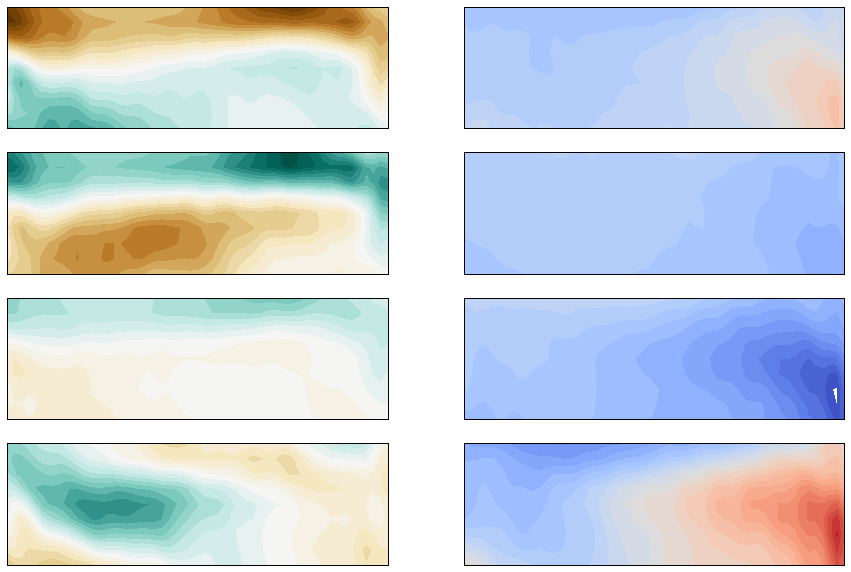

In [13]:
fig = plt.figure(figsize=(15,10), facecolor='white')
X_raw = x_scaler.inverse_transform(np.vstack([X_tr, X_ts]))
Y_raw = y_scaler.inverse_transform(np.vstack([Y_tr, Y_ts]))

levels = np.linspace(-4,4,30)
for x_cluster_id in range(4):
    ax = plt.subplot2grid((4,2), (x_cluster_id, 0))  
    # Plot the cluster's mean difference from all frames' mean.
    cluster_mean = (X_raw[x_lbls==x_cluster_id].mean(axis=0)-X_raw.mean(axis=0)).reshape(imshape).T
    im=ax.contourf(coords['x'].ravel(), coords['y'].ravel(), cluster_mean, levels=levels, cmap='BrBG_r')
    ax.set_xticks([]); ax.set_yticks([])

levels=np.linspace(-3,5.5,30)
for y_cluster_id in range(4):
    ax = plt.subplot2grid((4,2), (y_cluster_id, 1))  
    # Plot the cluster's mean difference from all frames' mean.
    cluster_mean = (Y_raw[y_lbls==y_cluster_id].mean(axis=0)-Y_raw.mean(axis=0)).reshape(imshape).T

    im=ax.contourf(coords['x'].ravel(), coords['y'].ravel(), cluster_mean, levels=levels, cmap='coolwarm')
    ax.set_xticks([]); ax.set_yticks([])

# Compute and print P(y_lbl | x_lbl)
P_CE = np.array([np.bincount(y_lbls.astype(int)[x_lbls==x_lbl], 
    minlength=y_lbls.max()+1).astype(float) for x_lbl in np.sort(np.unique(x_lbls))])
P_CE = P_CE/P_CE.sum()
P_E_given_C = P_CE/P_CE.sum(axis=1, keepdims=True)

print('P(TempCluster | WindCluster):')
print(P_E_given_C)